In [105]:
import os
import glob
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

In [106]:
# Constants
IMAGE_SIZE = 48
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 25
TRAIN_DIR = "images/train"
VAL_DIR = "images/validation"

In [107]:
# Load images and labels
def load_data(directory):
    images = []
    labels = []
    label_map = {'angry': 0, 'disgusted': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprised': 5, 'neutral': 6}
    
    for label, idx in label_map.items():
        image_paths = glob.glob(os.path.join(directory, label, "*.jpg"))
        print(f"Loading images for label '{label}': {image_paths}")
        for image_path in image_paths:
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            images.append(image)
            labels.append(idx)
            
    return np.array(images), np.array(labels, dtype=np.int32)

In [108]:
# Load training and validation data
X_train, y_train = load_data(TRAIN_DIR)
X_val, y_val = load_data(VAL_DIR)

Loading images for label 'angry': ['images/train\\angry\\0.jpg', 'images/train\\angry\\1.jpg', 'images/train\\angry\\10.jpg', 'images/train\\angry\\10002.jpg', 'images/train\\angry\\10016.jpg', 'images/train\\angry\\10037.jpg', 'images/train\\angry\\10038.jpg', 'images/train\\angry\\10057.jpg', 'images/train\\angry\\10063.jpg', 'images/train\\angry\\10069.jpg', 'images/train\\angry\\10100.jpg', 'images/train\\angry\\10105.jpg', 'images/train\\angry\\10115.jpg', 'images/train\\angry\\10122.jpg', 'images/train\\angry\\10142.jpg', 'images/train\\angry\\1015.jpg', 'images/train\\angry\\10154.jpg', 'images/train\\angry\\10155.jpg', 'images/train\\angry\\10158.jpg', 'images/train\\angry\\1016.jpg', 'images/train\\angry\\10167.jpg', 'images/train\\angry\\10178.jpg', 'images/train\\angry\\1018.jpg', 'images/train\\angry\\10181.jpg', 'images/train\\angry\\10192.jpg', 'images/train\\angry\\10196.jpg', 'images/train\\angry\\10202.jpg', 'images/train\\angry\\10207.jpg', 'images/train\\angry\\10214

In [109]:
# Print the shape of the loaded data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (25180, 48, 48)
y_train shape: (25180,)
X_val shape: (6158, 48, 48)
y_val shape: (6158,)


In [110]:
# Normalize and reshape the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
X_val = X_val.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

In [111]:
# Convert label arrays to integers and one-hot encode
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_train = np.eye(NUM_CLASSES, dtype=np.float32)[y_train]
y_val = np.eye(NUM_CLASSES, dtype=np.float32)[y_val]

# Ensure labels have the correct shape
y_train = y_train.reshape(-1, NUM_CLASSES)
y_val = y_val.reshape(-1, NUM_CLASSES)

# Image data augmentation
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [112]:
#Applying CNN 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold


def create_model(learning_rate, input_shape):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    for layer in model.layers[:10]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(x_train, y_train, batch_size, epochs, learning_rate, input_shape, k_folds):
    kf = KFold(n_splits=k_folds)
    accuracies = []
    for train_index, val_index in kf.split(x_train):
        train_datagen = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False
        )
        val_datagen = ImageDataGenerator()

        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        train_datagen.fit(x_train_fold)
        val_datagen.fit(x_val_fold)

        train_generator = train_datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size)
        val_generator = val_datagen.flow(x_val_fold, y_val_fold, batch_size=batch_size)

        model = create_model(learning_rate, input_shape)

        K4model = model.fit_generator(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=epochs,
                                      validation_data=val_generator,
                                      validation_steps=len(val_generator))
        accuracies.append(K4model.history['val_accuracy'])
    return accuracies


In [114]:
#Model Training
model.fit(data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
          validation_data=(X_val, y_val),
          steps_per_epoch=len(X_train) // BATCH_SIZE,
          epochs=EPOCHS)

Epoch 1/25
393/393 [==============================] - 175s 446ms/step - loss: 1.5202 - accuracy: 0.3376 - val_loss: 1.4282 - val_accuracy: 0.4297
Epoch 2/25
393/393 [==============================] - 175s 447ms/step - loss: 1.4676 - accuracy: 0.3729 - val_loss: 1.3287 - val_accuracy: 0.4596
Epoch 3/25
393/393 [==============================] - 175s 446ms/step - loss: 1.4144 - accuracy: 0.4038 - val_loss: 1.2441 - val_accuracy: 0.4867
Epoch 4/25
393/393 [==============================] - 175s 445ms/step - loss: 1.3692 - accuracy: 0.4271 - val_loss: 1.2233 - val_accuracy: 0.5029
Epoch 5/25
393/393 [==============================] - 172s 438ms/step - loss: 1.3323 - accuracy: 0.4480 - val_loss: 1.1826 - val_accuracy: 0.5177
Epoch 6/25
393/393 [==============================] - 174s 442ms/step - loss: 1.3067 - accuracy: 0.4611 - val_loss: 1.1531 - val_accuracy: 0.5403
Epoch 7/25
393/393 [==============================] - 172s 437ms/step - loss: 1.2807 - accuracy: 0.4787 - val_loss: 1.1348 -

In [115]:
# Save the trained model
model.save("emotion_classifier.h5")


Epoch 1/25
393/393 [==============================] - 183s 467ms/step - loss: 1.1368 - accuracy: 0.5395 - val_loss: 1.0228 - val_accuracy: 0.5927
Epoch 2/25
393/393 [==============================] - 179s 456ms/step - loss: 1.1351 - accuracy: 0.5430 - val_loss: 1.0121 - val_accuracy: 0.5953
Epoch 3/25
393/393 [==============================] - 179s 456ms/step - loss: 1.1284 - accuracy: 0.5449 - val_loss: 0.9975 - val_accuracy: 0.6028
Epoch 4/25
393/393 [==============================] - 178s 454ms/step - loss: 1.1290 - accuracy: 0.5423 - val_loss: 1.0070 - val_accuracy: 0.6000
Epoch 5/25
393/393 [==============================] - 179s 456ms/step - loss: 1.1312 - accuracy: 0.5461 - val_loss: 1.0070 - val_accuracy: 0.6043
Epoch 6/25
393/393 [==============================] - 177s 450ms/step - loss: 1.1275 - accuracy: 0.5456 - val_loss: 1.0015 - val_accuracy: 0.6021
Epoch 7/25
393/393 [==============================] - 177s 450ms/step - loss: 1.1190 - accuracy: 0.5513 - val_loss: 0.9930 -

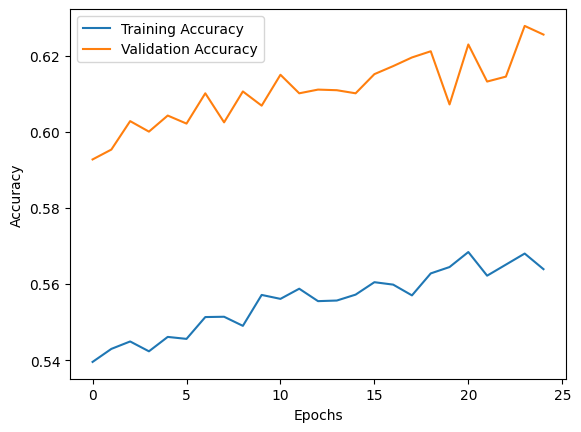

NameError: name 'batch_size' is not defined

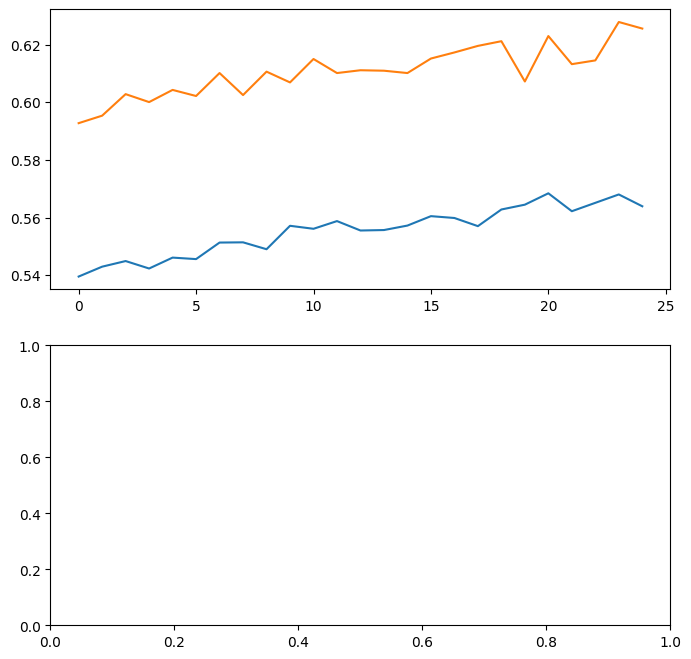

In [116]:
# Plot the Graphs

import matplotlib.pyplot as plt
# Fit the model and save the history
history = model.fit(data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(X_val, y_val),
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    epochs=EPOCHS)
# Plot the training accuracy vs validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot the training and validation accuracy and loss
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title(f"Accuracy: batch_size={batch_size}, num_epochs={num_epoch}")
axs[0].legend()
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title(f"Loss: batch_size={batch_size}, num_epochs={num_epoch}")
axs[1].legend()
plt.show()